### Project
### Part A: IMDb Movie Review Sentiment Analysis
#### 1. Overview
Sentiment analysis is a natural language processing (NLP) task that involves determining
whether a given text expresses a positive or negative sentiment. In this project, we will
analyze movie reviews from the IMDb dataset and predict the sentiment (positive or
negative) based on the text of the reviews. By leveraging various text preprocessing
techniques, feature extraction methods, and classification algorithms, this project will
develop a machine learning model capable of accurately predicting the sentiment of movie
reviews. The insights derived from this analysis can be useful for movie producers, critics,
and platforms like IMDb to understand public opinion and tailor marketing or content
strategies accordingly.
#### 2. Problem Statement
The primary objective of this project is to build a machine learning classification model that
can predict the sentiment of IMDb movie reviews. The dataset contains a collection of movie
reviews, and each review is labeled as either positive or negative.
Using text preprocessing, feature extraction techniques (such as TF-IDF), and various
classification algorithms, the project will aim to develop a model that can effectively classify
the sentiment of movie reviews. The model's performance will be evaluated using standard
classification metrics, such as accuracy, precision, recall, and F1-score.
#### 3. Dataset Information
The IMDb dataset contains a large number of movie reviews, each labeled with either a
positive or negative sentiment.
* Text of the review: The actual review provided by the user.
* Sentiment label: The sentiment of the review, either "positive" or "negative."
#### Dataset: [Imdb](https://docs.google.com/spreadsheets/d/106x15uz8ccQ6Wvpc8-sYjXisBN8vewS435I7z3wd4sw/edit?gid=1889101679#gid=1889101679)

In [1]:
# Import important library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# upload dataset
url = 'https://docs.google.com/spreadsheets/d/106x15uz8ccQ6Wvpc8-sYjXisBN8vewS435I7z3wd4sw/export?format=csv&gid=1889101679'
df = pd.read_csv(url)
# Display the few rows of data
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.duplicated().sum()

419

In [5]:
df[df.duplicated()].index

Index([ 3537,  3769,  4391,  6352,  6479,  6672,  7221,  7222,  7425,  7555,
       ...
       49361, 49595, 49695, 49781, 49871, 49912, 49950, 49984, 49986, 49991],
      dtype='int64', length=419)

In [6]:
duplicate = df[df.duplicated()]
count = duplicate['sentiment'].value_counts()
count

sentiment
negative    303
positive    116
Name: count, dtype: int64

* There is 419 duplicate values.

In [7]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [8]:
# Basic review statistics
df['review_length'] = df['review'].apply(len)
df['review_word_count'] = df['review'].apply(lambda x: len(x.split()))
df.describe()

,review_length,review_word_count
count,49581.000000,49581.000000
mean,1310.530707,231.344366
std,990.786752,171.546644
min,7.000000,1.000000
25%,699.000000,126.000000
50%,971.000000,173.000000
75%,1592.000000,281.000000
max,13704.000000,2470.000000


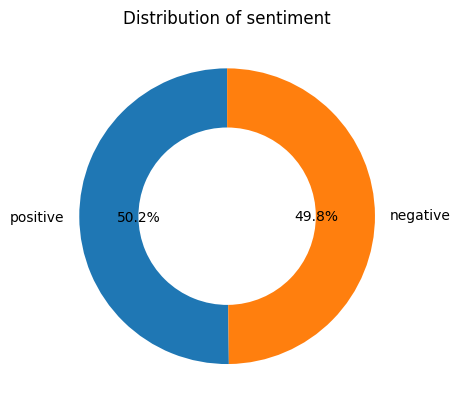

In [9]:
# Donut plot
count = df['sentiment'].value_counts()
plt.pie(count, labels=count.index,autopct='%1.1f%%',
       startangle=90,wedgeprops=dict(width=0.4))
plt.title("Distribution of sentiment")
plt.show()

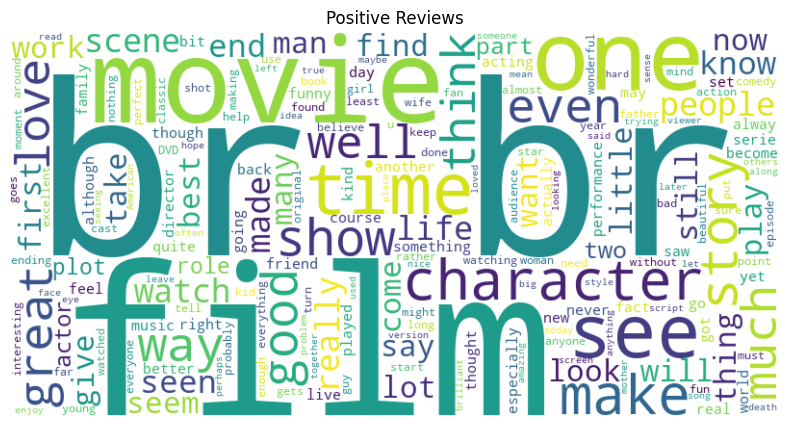

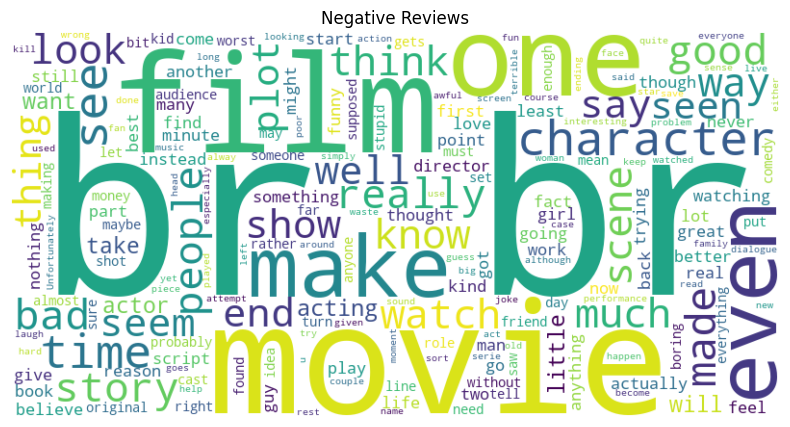

In [10]:
# Word cloud of review type
review_type = ['positive','negative']
for col in review_type:
    review_text = ' '.join(df[df['sentiment']==col]['review'])
    wordcloud = WordCloud(width=800,height=400,background_color='white').generate(review_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{col.capitalize()} Reviews')

#### Review cleaning and Tokenization

In [11]:
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    text = text.lower()                 #Lowercase
    text = re.sub(r'<.*?>',' ',text)    #Remove HTML
    text = re.sub(r'[^a-z\s]','',text)  # remove special chars
    tokens = word_tokenize(text)        # Tokenize
    tokens = [word for word in tokens if word not in stop_words and len(word)>2] # remove stopwords & short words
    tokens = [word for word in tokens if not re.search(r'(.)\1{2,}', word)] # remove junk words
    return tokens
    

#### POS Tagging Helper

In [12]:
def get_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN,
               "V": wordnet.VERB, "R": wordnet.ADJ}
    return tag_dict.get(tag, wordnet.NOUN)

#### Lemmatization

In [13]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(w, pos = get_pos(w)) for w in tokens]

In [14]:
# apply pipeline
df['tokens'] = df['review'].apply(clean_and_tokenize)
df['lemmatize_review'] = df['tokens'].apply(lemmatize_tokens)

In [15]:
print("Original Review:\n", df['review'][1])
print("Tokens:\n", df['tokens'][1])
print("Lemmatize Review:\n", df['lemmatize_review'][1])

Original Review:
 A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are ter

In [16]:
df['lemmatized_text'] = df['lemmatize_review'].apply(lambda x:' '.join(x))
df['lemmatized_text'][1]

'wonderful little production film technique unassuming oldtimebbc fashion give comfort sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen get polari voice pat truly see seamless edit guide reference williams diary entry well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concern orton halliwell set particularly flat halliwells mural decorate every surface terribly well do'

#### Bag of Words Model

In [17]:
# create the BoW 
bow_vector = CountVectorizer()
x_bow = bow_vector.fit_transform(df['lemmatized_text'])

In [18]:
print("BoW Shape:", x_bow.shape)
print(x_bow[:5].toarray())

BoW Shape: (49581, 142539)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


* Bag of Words (BoW) is a way of turning text into numbers by counting how many times each word appears, without caring about the order of the words.

##### TF-IDF (Term Frequency-Inverse Document Frequency) Model

In [19]:
tfidf_vector = TfidfVectorizer()
x_tfidf = tfidf_vector.fit_transform(df['lemmatized_text'])

In [20]:
print("TF-IDF Shape:", x_tfidf.shape)
print(x_tfidf[:5].toarray())

TF-IDF Shape: (49581, 142539)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
print("Features Names Words:")
print(tfidf_vector.get_feature_names_out())

Features Names Words:
['aab' 'aachen' 'aada' ... 'zylbersteinand' 'zyuranger' 'zzvorkov']


* TF-IDF (Term Frequency–Inverse Document Frequency) is a method to show how important a word is in a document compared
  to all other documents in a collection. It gives higher weight to words that appear often in one document but not in many others.

#### Word Embeddings (Word2Vec) 

In [22]:
sentences = df['lemmatize_review'].tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2)

# Check vector for a word
print(w2v_model.wv['good'])
# Find similar words
print(w2v_model.wv.most_similar('good'))

[ 2.1507635   0.03672148  0.11628633  0.7406002  -0.26184106  1.7477306
  1.1967735   1.0772961  -0.17955795  0.3528596  -0.74242514 -0.41818368
  1.7221779   0.5749569  -0.2316197  -1.5376693  -0.27574584  0.7352146
 -0.16656645 -1.3659701   2.423236   -0.9215658   0.7472119  -0.3336755
 -2.0800977  -1.2760149   0.11787016  1.4468589   1.2458686  -0.38871792
  0.6703656   0.19871342 -0.07531717  0.08865833 -0.28413886 -0.77821016
 -1.0948571  -2.1492918  -2.518586    0.92019516 -0.6241568  -0.69608283
  0.87571687 -1.1519781  -0.34447762  1.9724257   1.2018045  -1.6106585
 -1.5932426   1.1795683  -0.74366003 -1.4330827   1.1698228   1.2090749
  0.03102433  0.4545941  -0.0436479  -1.6923305  -0.62273026 -1.3843877
  0.58472925 -1.7990755   0.61390907  0.23240247  0.1844779   1.175492
 -0.1365167   0.84630233 -2.4363248   0.02437478  0.9711344   0.34951517
  1.2557424   1.0430825   0.79660606 -0.43914607  0.7742812   2.800064
 -0.32489443 -0.5951438  -1.3405395   2.1544771  -1.0556619  

In [23]:
# Convert each review to average word vector
def avg_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]  # get vectors for known words
    if len(vectors) == 0:
        return np.zeros(model.vector_size)  # if no known words
    return np.mean(vectors, axis=0)  # average along rows

In [24]:
df['embedding'] = df['lemmatize_review'].apply(lambda x: avg_vector(x,w2v_model))

In [25]:
df['embedding'][1]

array([ 0.27932355, -0.15149397,  0.00748965, -0.17706399, -0.21280633,
       -0.13831048,  0.3567438 ,  0.3411154 ,  0.0262637 , -0.21002509,
        0.11739308, -0.29663974, -0.03950404, -0.08181837,  0.25352713,
       -0.1875589 ,  0.36549622,  0.34199032, -0.18470894, -0.47063687,
        0.61294633,  0.11691757,  0.20438842, -0.23601192, -0.48620638,
       -0.04962057, -0.55654764,  0.50467783,  0.04127947, -0.17580053,
        0.33070606, -0.07461364,  0.21191257, -0.413225  , -0.2865333 ,
        0.47808194, -0.21168515, -0.64052236, -0.605779  ,  0.12221193,
        0.20601553, -0.14885491,  0.3036209 ,  0.10244665,  0.33737996,
       -0.05230565,  0.29189083, -0.47159675,  0.48976532,  0.26015094,
       -0.18072869, -0.42601985,  0.22981234, -0.0612383 ,  0.10866015,
       -0.21170437,  0.2261249 , -0.23006296, -0.02033942,  0.28015253,
       -0.06989787, -0.21152674,  0.4804979 , -0.4793817 , -0.26094356,
        0.6144102 , -0.04166071,  0.11754251, -0.5934591 ,  0.06

In [26]:
# Map sentiment variable to binary values
df['sentiment_binary'] = df['sentiment'].map({'positive':1, 'negative':0})
df['sentiment_binary'].unique()

array([1, 0], dtype=int64)

In [27]:
x = np.vstack(df['embedding'].values)  # Convert list to matrix
y = df['sentiment_binary']

# train test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [28]:
print("Training set Size:", x_train.shape)
print("Testing Set Size:", x_test.shape)

Training set Size: (39664, 100)
Testing Set Size: (9917, 100)


In [29]:
models = [LogisticRegression(max_iter=1000),
         GaussianNB(),
         RandomForestClassifier(n_estimators=100, random_state=42)
         ]

In [30]:
def evaluate_models(models,x_train,x_test,y_train,y_test):
    for model in models:
        model.fit(x_train,y_train)

        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:,1]

        acc = accuracy_score(y_test,y_pred)
        roc_auc = roc_auc_score(y_test,y_prob)
        cr = classification_report(y_test,y_pred)

        print("="*60)
        print(f"model: {model.__class__.__name__}")
        print(f"Accuracy: {acc:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"Classification Report:\n", cr)

In [31]:
evaluate_models(models, x_train, x_test, y_train, y_test)

model: LogisticRegression
Accuracy: 0.8632
ROC-AUC: 0.9356
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      4995
           1       0.86      0.87      0.86      4922

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

model: GaussianNB
Accuracy: 0.7734
ROC-AUC: 0.8519
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77      4995
           1       0.77      0.78      0.77      4922

    accuracy                           0.77      9917
   macro avg       0.77      0.77      0.77      9917
weighted avg       0.77      0.77      0.77      9917

model: RandomForestClassifier
Accuracy: 0.8433
ROC-AUC: 0.9158
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84   

* Logistic Regression performed best with highest accuracy (86%) and ROC-AUC (93%).

* Random Forest gave slightly lower accuracy (83.8%) but still a good ROC-AUC (91%).

* GaussianNB had the lowest performance among the three models.

#### Neural Networks (LSTM) Long Short-Term Memory

In [32]:
# Import Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
x_text = df['lemmatized_text']   # lemmatized_text is clean (string)
y = df['sentiment_binary']

In [34]:
# Tokenizer settings
max_words = 10000 # Maximum vocabulary size
max_len = 200    # # Maximum sequence length (truncate/pad to 200 words)

tokenizer = Tokenizer(num_words = max_words, oov_token="<OOV>")     # If a word was not seen during training, it will be replaced by <OOV> out of vocab.
tokenizer.fit_on_texts(x_text)


In [35]:
# Convert text to sequences
x_seq = tokenizer.texts_to_sequences(x_text)
# Pad sequences to make same length
x_pad = pad_sequences(x_seq, maxlen = max_len, padding='post', truncating='post')

# train test split
x_train, x_test, y_train, y_test = train_test_split(x_pad, y, test_size=0.2, random_state=42)

In [36]:
model = Sequential([
    Embedding(input_dim = max_words, output_dim = 64, input_length = max_len),   # Word embeddings
    LSTM(64),           # LSTM layer with 64 units
    Dropout(0.3),       # Dropout to prevent overfitting
    Dense(1, activation = 'sigmoid')   # Output layer (binary classification)
])
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [37]:
model.build(input_shape=(None,max_len))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)
# Train the model
history = model.fit(x_train,y_train, epochs=10, batch_size=64, validation_split=0.2,callbacks=[early_stop],verbose=1)

Epoch 1/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 117s 215ms/step - accuracy: 0.5022 - loss: 0.6936 - val_accuracy: 0.5123 - val_loss: 0.6922
Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 105s 212ms/step - accuracy: 0.5392 - loss: 0.6841 - val_accuracy: 0.5341 - val_loss: 0.6831
Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 104s 210ms/step - accuracy: 0.5451 - loss: 0.6650 - val_accuracy: 0.5311 - val_loss: 0.6731
Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 70s 140ms/step - accuracy: 0.6048 - loss: 0.6214 - val_accuracy: 0.6063 - val_loss: 0.6447
Epoch 5/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 99s 200ms/step - accuracy: 0.6756 - loss: 0.5668 - val_accuracy: 0.5651 - val_loss: 0.6867
Epoch 6/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 99s 199ms/step - accuracy: 0.6385 - loss: 0.5724 - val_accuracy: 0.8215 - val_loss: 0.4322
Epoch 7/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 99s 199ms/step - accuracy: 0.8746 - loss: 0.3272 - val_accuracy: 0.8591 - val_loss: 0.3401
Epoch 8/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 101s 204ms/step - accuracy: 0.9208 - los

In [39]:
# Get predicted probabilities
y_prob = model.predict(x_test).ravel()
# Convert to 0/1 predictions
y_pred = (y_prob >= 0.5).astype(int)

# calculate metrics
accu = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
CR = classification_report(y_test, y_pred)

310/310 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step


In [40]:
print(f"Accuracy: {accu:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Classification Report:\n", CR)

Accuracy: 0.8677
ROC-AUC: 0.9339
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      4995
           1       0.86      0.88      0.87      4922

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



* The LSTM model achieved accuracy = 85.4% and ROC-AUC score = 91.9%.

* It performs almost equally well for both classes (positive and negative).

* Precision and recall are balanced for both classes (around 0.84–0.87).

* Overall, the model shows good classification performance for sentiment analysis.

#### Predictions for new movie reviews

In [50]:
def predict_new_review(review_text):
    clean_text = clean_and_tokenize(review_text)
    lemma = lemmatize_tokens(clean_text)
    seq = tokenizer.texts_to_sequences([" ".join(lemma)])
    pad_seq = pad_sequences(seq, maxlen= max_len, padding='post', truncating='post')
    prob = model.predict(pad_seq)[0][0]
    sentiment = "Positive" if prob >= 0.5 else "Negative"
    return sentiment, prob

In [51]:
reviews = [
    "The movie was amazing and emotional!",
    "It was a boring film with bad acting."
]

In [52]:
for r in reviews:
    sentiment,prob = predict_new_review(r)
    print(f"Review: {r}")
    print(f"Predicted Sentiment: {sentiment} (Prob: {prob:.2f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Review: The movie was amazing and emotional!
Predicted Sentiment: Positive (Prob: 0.81)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Review: It was a boring film with bad acting.
Predicted Sentiment: Negative (Prob: 0.08)

